In [9]:
import numpy as np
import random

# Constants
sound_speed = 340  # m/s
lat_conversion = 111263  # meters per degree of latitude
lon_conversion = 97304   # meters per degree of longitude

# Device locations (longitude, latitude, height)
device_locations = np.array([
    [110.241, 27.204, 824],
    [110.783, 27.456, 727],
    [110.762, 27.785, 742],
    [110.251, 28.025, 850],
    [110.524, 27.617, 786],
    [110.467, 28.081, 678],
    [110.047, 27.521, 575]
])

# Sound arrival times at each device
sound_times = np.array([
    [100.767, 164.229, 214.850, 270.065],
    [92.453, 112.220, 169.362, 196.583],
    [75.560, 110.696, 156.936, 188.020],
    [94.653, 141.409, 196.517, 258.985],
    [78.600, 86.216, 118.443, 126.669],
    [67.274, 166.270, 175.482, 266.871],
    [103.738, 163.024, 206.789, 210.306]
])

# Convert latitude and longitude to Cartesian coordinates for distance calculation
def lat_lon_to_cartesian(lon, lat, h):
    x = lon * lon_conversion
    y = lat * lat_conversion
    return np.array([x, y, h])

# Calculate the time delay from each device to a potential explosion point using absolute coordinates
def time_delay(device, explosion_point, explosion_time):
    device_cartesian = lat_lon_to_cartesian(*device)
    explosion_cartesian = lat_lon_to_cartesian(*explosion_point)
    distance = np.linalg.norm(device_cartesian - explosion_cartesian)
    time_diff = distance / sound_speed
    return explosion_time + time_diff

# Fitness function: evaluate the total error of the sound arrival times and add penalty for time constraints
def fitness(solution):
    explosion_times = solution[:4]
    explosion_positions = solution[4:].reshape((4, 3))
    
    total_error = 0
    penalty = 0

    # Check the conditions for each explosion time
    for i in range(4):
        # Ensure explosion time is greater than zero
        if explosion_times[i] <= 0:
            penalty += 1000  # Large penalty for negative or zero times
        
        # Ensure explosion time is less than the minimum arrival time for each device
        for j in range(7):
            min_arrival_time = np.min(sound_times[j])
            if explosion_times[i] >= min_arrival_time:
                penalty += 1000  # Large penalty for exceeding the minimum arrival time

    # Calculate RMSE for the sound arrival times
    for i in range(7):  # For each device
        for j in range(4):  # For each explosion
            predicted_time = time_delay(device_locations[i], explosion_positions[j], explosion_times[j])
            total_error += (predicted_time - sound_times[i, j]) ** 2  # Squared error
    
    # Add penalty if the time differences between explosions exceed 5 seconds
    for i in range(4):
        for j in range(i + 1, 4):
            if abs(explosion_times[i] - explosion_times[j]) > 5:
                penalty += 1000  # Arbitrary large penalty value for violation

    return np.sqrt(total_error) + penalty  # RMSE with penalty

# Initial population generation
def generate_initial_population(pop_size):
    population = []
    for _ in range(pop_size):
        explosion_times = np.random.uniform(1, 200, 4)  # Random initial times, starting from 1 to ensure positive values
        explosion_positions = np.random.uniform([110.0, 27.0, 500], [111.0, 28.0, 900], (4, 3))  # Random positions in lat/lon/altitude
        solution = np.concatenate([explosion_times, explosion_positions.flatten()])
        population.append(solution)
    return population

# Selection, crossover, and mutation operations with elite preservation
def evolve_population(population, elite_size=1, generation_num=1, max_generations=500):
    # Sort population by fitness
    population = sorted(population, key=fitness)
    
    # Elite preservation: retain the best solutions
    new_population = population[:elite_size]
    
    # Adaptive mutation rate
    mutation_rate = max(0.1, 1.0 - (generation_num / max_generations))  # Decaying mutation rate
    
    # Crossover and mutation
    while len(new_population) < len(population):
        parents = random.sample(population[:len(population)//2], 2)  # Select from best half
        cross_point = random.randint(1, len(parents[0]) - 1)
        child = np.concatenate([parents[0][:cross_point], parents[1][cross_point:]])
        
        # Mutation
        if random.random() < mutation_rate:
            mutation_index = random.randint(0, len(child) - 1)
            child[mutation_index] += np.random.uniform(-1, 1)
        
        new_population.append(child)
    
    return new_population

# Particle Swarm Optimization
class Particle:
    def __init__(self, dimensions):
        self.position = np.random.uniform(1, 200, dimensions)
        self.velocity = np.random.uniform(-1, 1, dimensions)
        self.best_position = self.position.copy()
        self.best_fitness = float('inf')

def particle_swarm_optimization(best_solution, num_particles=50, max_iterations=1000, w=0.5, c1=1.5, c2=1.5):
    dimensions = len(best_solution)
    swarm = [Particle(dimensions) for _ in range(num_particles)]

    global_best_position = best_solution.copy()
    global_best_fitness = fitness(global_best_position)

    for iteration in range(max_iterations):
        for particle in swarm:
            # Update particle's fitness
            particle_fitness = fitness(particle.position)

            # Update personal best
            if particle_fitness < particle.best_fitness:
                particle.best_position = particle.position.copy()
                particle.best_fitness = particle_fitness

            # Update global best
            if particle_fitness < global_best_fitness:
                global_best_position = particle.position.copy()
                global_best_fitness = particle_fitness

        for particle in swarm:
            # Update velocity
            particle.velocity = (
                w * particle.velocity +
                c1 * np.random.rand() * (particle.best_position - particle.position) +
                c2 * np.random.rand() * (global_best_position - particle.position)
            )

            # Update position
            particle.position += particle.velocity

        # Print progress
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Best fitness: {global_best_fitness}")

    return global_best_position

# Genetic algorithm with elite preservation and PSO
def genetic_algorithm_with_pso(pop_size=300, generations=1000, elite_size=5):
    population = generate_initial_population(pop_size)

    for generation in range(generations):
        population = evolve_population(population, elite_size, generation, generations)

        # Track the best solution found
        best_solution = min(population, key=fitness)
        best_fitness = fitness(best_solution)
        
        print(f"Generation {generation}: Best fitness = {best_fitness}")

        # If fitness is good enough, stop early
        if best_fitness < 100:
            break
    
    # After genetic algorithm finishes, perform PSO for local search
    best_solution = particle_swarm_optimization(best_solution)
    
    return best_solution

# Run the optimized genetic algorithm with PSO
best_solution = genetic_algorithm_with_pso()

# Extract the results
explosion_times = best_solution[:4]
explosion_positions = best_solution[4:].reshape((4, 3))

# Calculate final error
total_error = fitness(best_solution)

# Output the final explosion times and positions with error
print("Best explosion times:", explosion_times)
print("Best explosion positions (longitude, latitude, height):", explosion_positions)
print("Total error (RMSE):", total_error)


Generation 0: Best fitness = 5522.0891330739805
Generation 1: Best fitness = 5426.592639721455
Generation 2: Best fitness = 4608.764250702066
Generation 3: Best fitness = 4552.863174884567
Generation 4: Best fitness = 3862.985840954205
Generation 5: Best fitness = 3658.7295921347295
Generation 6: Best fitness = 2403.60401552422
Generation 7: Best fitness = 2403.60401552422
Generation 8: Best fitness = 1625.2580479697647
Generation 9: Best fitness = 597.5656741137792
Generation 10: Best fitness = 588.9826680034809
Generation 11: Best fitness = 466.27578728918775
Generation 12: Best fitness = 389.0975082577564
Generation 13: Best fitness = 347.4701867003381
Generation 14: Best fitness = 347.4701867003381
Generation 15: Best fitness = 295.7366736268893
Generation 16: Best fitness = 295.7366736268893
Generation 17: Best fitness = 285.49089122047934
Generation 18: Best fitness = 280.24983761207613
Generation 19: Best fitness = 279.1018944253852
Generation 20: Best fitness = 277.556196965573

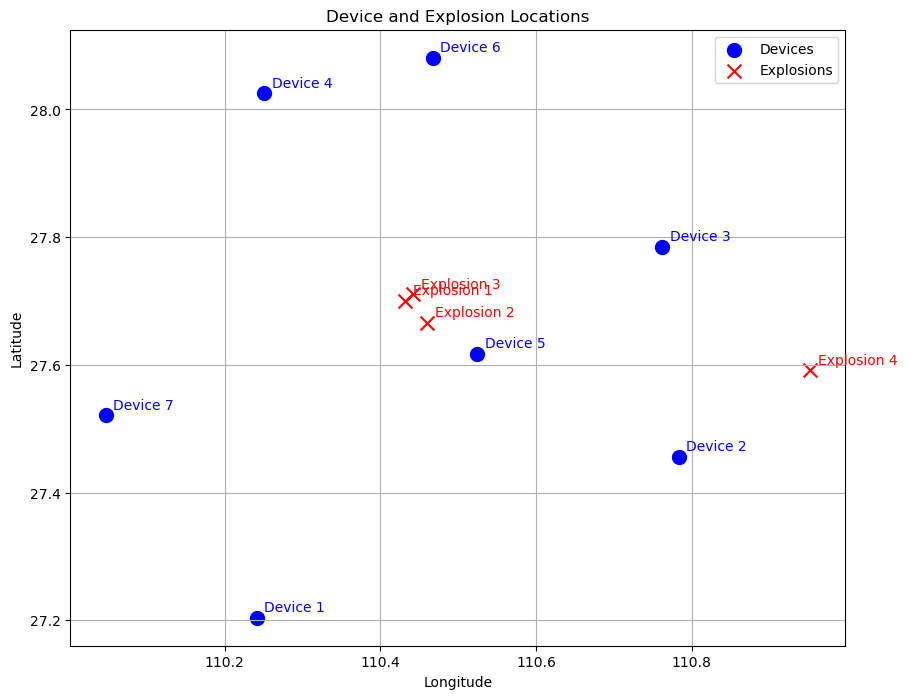

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Device locations (longitude, latitude, height)
device_locations = np.array([
    [110.241, 27.204, 824],
    [110.783, 27.456, 727],
    [110.762, 27.785, 742],
    [110.251, 28.025, 850],
    [110.524, 27.617, 786],
    [110.467, 28.081, 678],
    [110.047, 27.521, 575]
])

# Best explosion positions (longitude, latitude, height)
explosion_positions = np.array([
    [110.43229428, 27.69959271, 773.16170389],
    [110.45972478, 27.66572359, 562.5007344],
    [110.44161337, 27.71039823, 457.62733576],
    [110.95189292, 27.59129019, 789.20322411]
])

# Plot device locations (blue points)
plt.figure(figsize=(10, 8))
plt.scatter(device_locations[:, 0], device_locations[:, 1], c='blue', s=100, label='Devices', marker='o')

# Plot explosion positions (red points)
plt.scatter(explosion_positions[:, 0], explosion_positions[:, 1], c='red', s=100, label='Explosions', marker='x')

# Add labels for devices
for i, (lon, lat) in enumerate(device_locations[:, :2]):
    plt.text(lon + 0.01, lat + 0.01, f'Device {i+1}', color='blue')

# Add labels for explosions
for i, (lon, lat) in enumerate(explosion_positions[:, :2]):
    plt.text(lon + 0.01, lat + 0.01, f'Explosion {i+1}', color='red')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Device and Explosion Locations')

# Show legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [13]:
import numpy as np
import random

# Constants
sound_speed = 340  # m/s

# Device locations (longitude, latitude, height)
device_locations = np.array([
    [110.241, 27.204, 824],
    [110.783, 27.456, 727],
    [110.762, 27.785, 742],
    [110.251, 28.025, 850],
    [110.524, 27.617, 786],
    [110.467, 28.081, 678],
    [110.047, 27.521, 575]
])

# Best explosion times and positions obtained from previous optimization
predicted_explosion_times = np.array([28.58986215, 28.59011388, 33.58986214, 33.58890358])
predicted_explosion_positions = np.array([
    [110.43229428, 27.69959271, 773.16170389],
    [110.45972478, 27.66572359, 562.5007344],
    [110.44161337, 27.71039823, 457.62733576],
    [110.95189292, 27.59129019, 789.20322411]
])

# Device sound arrival times
sound_times = np.array([
    [100.767, 164.229, 214.850, 270.065],
    [92.453, 112.220, 169.362, 196.583],
    [75.560, 110.696, 156.936, 188.020],
    [94.653, 141.409, 196.517, 258.985],
    [78.600, 86.216, 118.443, 126.669],
    [67.274, 166.270, 175.482, 266.871],
    [103.738, 163.024, 206.789, 210.306]
])

# Calculate the predicted arrival time for a given explosion and device
def predicted_time(device_location, explosion_position, explosion_time):
    distance = np.linalg.norm(device_location - explosion_position)
    time_delay = distance / sound_speed
    return explosion_time + time_delay

# Fitness function to evaluate the total error and determine the best combination matrix
def fitness_combination(predicted_times, predicted_positions, combination_matrix):
    total_error = 0
    for i in range(7):  # For each device
        for j in range(4):  # For each explosion in the combination
            explosion_idx = combination_matrix[i, j]  # Get the explosion index
            predicted_arrival = predicted_time(device_locations[i], predicted_positions[explosion_idx], predicted_times[explosion_idx])
            actual_arrival = sound_times[i, j]
            total_error += (predicted_arrival - actual_arrival) ** 2  # Squared error
    return np.sqrt(total_error)

# Generate an initial population of valid combination matrices
def generate_initial_population(pop_size):
    population = []
    for _ in range(pop_size):
        # Create a valid combination matrix where each row contains a permutation of [0, 1, 2, 3]
        combination_matrix = np.array([np.random.permutation(4) for _ in range(7)])  # Each row is a valid permutation
        population.append(combination_matrix)
    return population

# Evolve the population to find the best combination matrix
def evolve_population_v2(population, elite_size=1, max_generations=100):
    for generation in range(max_generations):
        population = sorted(population, key=lambda cm: fitness_combination(predicted_explosion_times, predicted_explosion_positions, cm))
        new_population = population[:elite_size]
        
        while len(new_population) < len(population):
            parents = random.sample(population[:len(population)//2], 2)
            cross_point = random.randint(1, 3)
            child = np.vstack([parents[0][:cross_point], parents[1][cross_point:]])
            
            # Ensure child is valid (i.e., each row contains a permutation of [0, 1, 2, 3])
            for row in range(7):
                np.random.shuffle(child[row])
            
            new_population.append(child)
        
        population = new_population
        best_solution = min(population, key=lambda cm: fitness_combination(predicted_explosion_times, predicted_explosion_positions, cm))
        print(f"Generation {generation}, Best fitness: {fitness_combination(predicted_explosion_times, predicted_explosion_positions, best_solution)}")
        if fitness_combination(predicted_explosion_times, predicted_explosion_positions, best_solution) < 100:
            break
    
    return best_solution

# Genetic algorithm to find the best combination matrix for predicted data
def genetic_algorithm_combination_v2(pop_size=100, generations=200, elite_size=5):
    population = generate_initial_population(pop_size)
    best_combination_matrix = evolve_population_v2(population, elite_size, generations)
    return best_combination_matrix

# Run the updated genetic algorithm
best_combination_matrix_v2 = genetic_algorithm_combination_v2()

# Output the best combination matrix and its fitness (error)
print("Best combination matrix (7x4):")
print(best_combination_matrix_v2)

# Calculate the final error for the best combination matrix
final_error_v2 = fitness_combination(predicted_explosion_times, predicted_explosion_positions, best_combination_matrix_v2)
print("Total error (RMSE):", final_error_v2)


Generation 0, Best fitness: 714.9400512575319
Generation 1, Best fitness: 714.9400512575319
Generation 2, Best fitness: 714.9400512575319
Generation 3, Best fitness: 714.9400512575319
Generation 4, Best fitness: 714.9400512575319
Generation 5, Best fitness: 714.9400512575319
Generation 6, Best fitness: 714.9400512575319
Generation 7, Best fitness: 714.9400512575319
Generation 8, Best fitness: 714.9400512575319
Generation 9, Best fitness: 714.9400512575319
Generation 10, Best fitness: 714.9400512575319
Generation 11, Best fitness: 714.9400512575319
Generation 12, Best fitness: 714.9400512575319
Generation 13, Best fitness: 714.9400512575319
Generation 14, Best fitness: 714.2831869779276
Generation 15, Best fitness: 714.2831869779276
Generation 16, Best fitness: 714.2831869779276
Generation 17, Best fitness: 714.2831869779276
Generation 18, Best fitness: 713.8836588760347
Generation 19, Best fitness: 713.8836588760347
Generation 20, Best fitness: 713.8836588760347
Generation 21, Best fit